<center><img src="https://www.brainlatam.com/uploads/blog/decomposing-emotions-at-the-brain-level-using-a-novel-and-interactive-emotion-elicitation-task-1443.webp" width="300" height="250" /></center>

# <center> Emotions NLP Classification </center>

---
## Table of Contents
---

1. [Problem Statement](#section1)<br>
2. [Importing Packages](#section2)<br>
3. [Loading Data](#section3)<br>
  - 3.1 [Description of the Dataset](#section301)<br>
  - 3.2 [Basic EDA](#section302)<br>
4. [Data Preprocessing](#section4)<br>
5. [Model Building](#section5)<br>
6. [Prediction on test set](#section6)<br>
7. [Conclusion](#section7)

<a name=section1></a>

---
## 1. Problem Statement
---

- A ROBOTICS tech company is making a robot especially for the purpose of
 **detecting emotions** from the human statements.
- They want to detect some of the basic **emotions** like joy, sadness , fear , anger etc.

<br> 
<center><img src="https://www.verywellmind.com/thmb/YwJYR3y0yhvZjAeHyPZXPVX6V1E=/1500x1000/filters:no_upscale():max_bytes(150000):strip_icc()/an-overview-of-the-types-of-emotions-4163976-01-474bb455cfe74c3cb98ea46113e3108b.png" width="700px" height="450px"/></center>
<br> 

- The current process suffers from the following issues:

  - To detect emotions, they have to put an **extra effort** to classify each statements from various scenario

  - This process is very **slow**, **time-consuming**, and **inefficient**.

- The company has hired you as data science consultants. 

- They want to **automate** the emotions classification process to make it more efficient and deployable on robot.


<a name=section2></a>

---
## 2. Importing Packages
---

In [1]:
pip install text_hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 8.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
# for basic data processesing
import numpy as np 
import pandas as pd  

# for warnings
import warnings
warnings.filterwarnings('ignore')

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

# for preprocessing
from tqdm._tqdm_notebook import tqdm_notebook
import text_hammer as th

# for text data preparation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# for Label encoding
from tensorflow.keras.utils import to_categorical


# for getting weight vectors
import gensim.downloader as api

# # model buliding layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.keras.layers import Dropout

# for callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# for metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score

<a name=section3></a>

---
## 3. Loading Data
---



In [3]:
# loading train data
train_data=pd.read_csv("emotion_train.csv")
train_data.head()

,Id,Input,Sentiment
0,6491,i feel extremely discontent right now,sadness
1,7081,i havent gone a week without exaggerated eyeli...,sadness
2,7598,i feel so thrilled to share with my fans becau...,joy
3,15874,i wanted to because he loves me and i feel lik...,love
4,12871,i feel we should not be supporting these rebel...,love


In [4]:
# loading test data
test_data=pd.read_csv("emotion_test.csv")
test_data.head()

,Id,Input
0,10779,i could almost feel it as the flames singed an...
1,2247,i realise im sounding surprisingly like every ...
2,11765,i have all of that obviously because of what i...
3,14390,i cannot speak for others but all i know is i ...
4,388,im pretty happy but a little on the nauseated ...


<a name=section301></a>
### 3.1 Data Description

In [5]:
train_data.shape

(14400, 3)

In [6]:
test_data.shape

(3600, 2)

**Observation**
- There are **14400 rows** in train data with **3 columns**
- There are **3600 rows** in test data with **2 columns**

<a name=section302></a>
### 3.2 Basic EDA

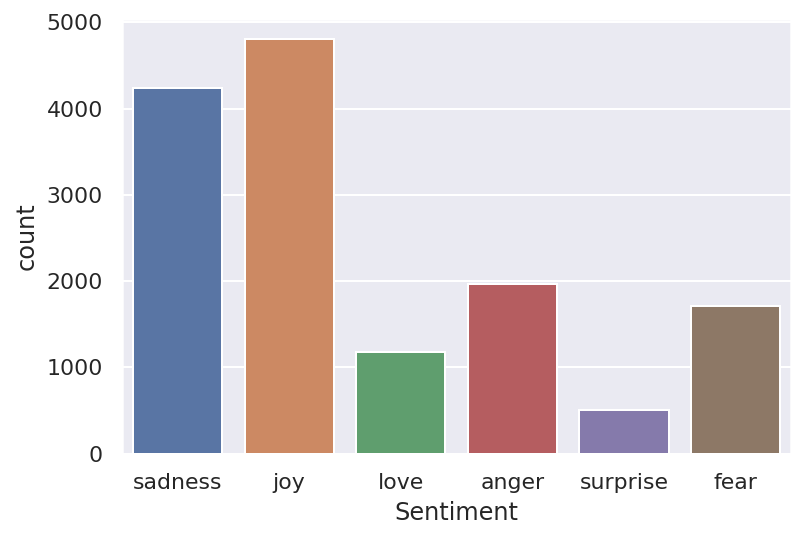

In [7]:
sns.countplot(train_data.Sentiment)
plt.show()

**Observation**
- **Most** of the statements are of **joy** .
- The **least** statements are of **surprise**.
- The sad statements are also in significant numbers.


In [8]:
# getting lenght of each sentence
length_of_sen= [len(ele) for ele in train_data['Input']]

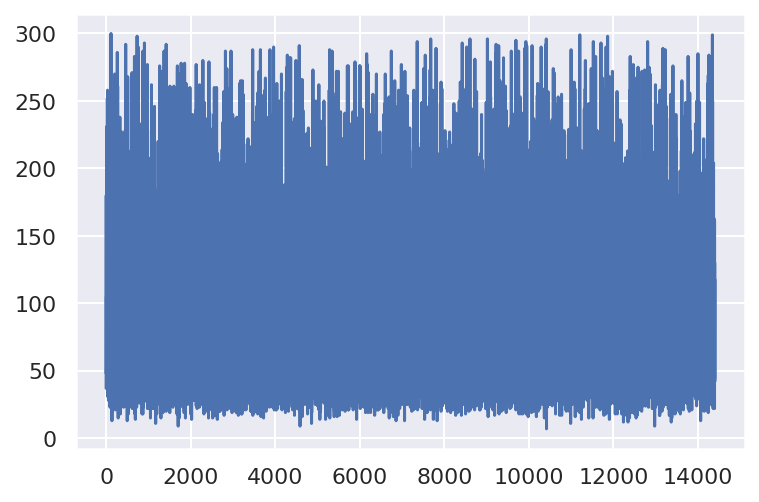

In [9]:
plt.plot(length_of_sen)
plt.show()

**Observation**
- We can easily see **most** of the **sentences** have more **200 words**.
- There are also **significant** amount of **sentences** having length more than **250 words**.
- From the plot it also seems like there are **few sentences** touching **300 word** length.

<a name=section4></a>

---
## 4. Data Preprocessing
---

In [10]:
%%time

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower()) # lower sentences
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x)) # removing html tags

# df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))  
# here we can remove stop-words but in this case removing not, and ,can change the meaning of context 

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x)) # removing special characters
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x)) 
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) # ran -> run
    return(df)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [11]:
# cleaning train data
cleaned_train_data = text_preprocessing(train_data, 'Input')

  0%|          | 0/14400 [00:00<?, ?it/s]

  0%|          | 0/14400 [00:00<?, ?it/s]

  0%|          | 0/14400 [00:00<?, ?it/s]

  0%|          | 0/14400 [00:00<?, ?it/s]

  0%|          | 0/14400 [00:00<?, ?it/s]

  0%|          | 0/14400 [00:00<?, ?it/s]

  0%|          | 0/14400 [00:00<?, ?it/s]

In [12]:
cleaned_train_data.head()

,Id,Input,Sentiment
0,6491,i feel extremely discontent right now,sadness
1,7081,i have not go a week without exaggerated eyeli...,sadness
2,7598,i feel so thrilled to share with my fan becaus...,joy
3,15874,i want to because he love me and i feel like i...,love
4,12871,i feel we should not be support these rebel in...,love


In [13]:
# cleaning test data
cleaned_test_data = text_preprocessing(test_data, 'Input')

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

In [14]:
cleaned_test_data.head()

,Id,Input
0,10779,i could almost feel it as the flame singe and ...
1,2247,i realise i m sound surprisingly like every ot...
2,11765,i have all of that obviously because of what i...
3,14390,i can not speak for other but all i know is i ...
4,388,i m pretty happy but a little on the nauseated...


##### Converting the text output  into integer (label encoding )

In [15]:
cleaned_train_data['Sentiment']=cleaned_train_data.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})


In [16]:
cleaned_train_data.head()

,Id,Input,Sentiment
0,6491,i feel extremely discontent right now,3
1,7081,i have not go a week without exaggerated eyeli...,3
2,7598,i feel so thrilled to share with my fan becaus...,0
3,15874,i want to because he love me and i feel like i...,2
4,12871,i feel we should not be support these rebel in...,2


**Observation**
- Here we can see our has been cleaned and the **label encoding** of **Sentiment** has been done

In [17]:
# tokenisation
num_words = 10000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
tokenizer.fit_on_texts(cleaned_train_data['Input'])

In [18]:
len(tokenizer.word_index) # this is whole unique words in our corpus
# but we are taking only 10000 words in our model

11504

In [19]:
# padding
X_train=tokenizer.texts_to_sequences(cleaned_train_data['Input']) # this converts texts into some numeric sequences 
X_train_pad=pad_sequences(X_train,maxlen=300,padding='post') # this makes the length of all numeric sequences equal 

X_test = tokenizer.texts_to_sequences(cleaned_test_data.Input)
X_test_pad = pad_sequences(X_test, maxlen = 300, padding = 'post')

In [20]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [21]:
# 
y_train = to_categorical(cleaned_train_data.Sentiment.values)

### Loading Embeding file

In [22]:
glove_gensim  = api.load('glove-wiki-gigaword-100') #100 dimension
# more dimension means more deep meaning of words but it may take longer time to download 

[==================================================] 100.0% 128.1/128.1MB downloaded


In [23]:
# Creating a word2Vec weight matrix
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [24]:
gensim_weight_matrix.shape

(10000, 100)

<a name=section5></a>

---
## 5.  Model Building
---

### Build the Model

- Let's build our model.

- Here, we'll use a `Sequential` model with Bi-LSTM and Dense layers.
- We add first layers as embedding layers to feed in our vectors to the LSTM layers.

In [25]:
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model = Sequential()
model.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dense(6, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [26]:
#using callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('bi_lstm_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [27]:
# training model
history = model.fit(X_train_pad,y_train, epochs = 25, batch_size = 120, validation_split=0.2 ,verbose = 1, callbacks= [es, mc]  )


Epoch 1/25
96/96 [==============================] - ETA: 0s - loss: 1.4671 - accuracy: 0.4356
Epoch 1: val_accuracy improved from -inf to 0.51632, saving model to bi_lstm_model.h5
96/96 [==============================] - 31s 200ms/step - loss: 1.4671 - accuracy: 0.4356 - val_loss: 1.3184 - val_accuracy: 0.5163
Epoch 2/25
96/96 [==============================] - ETA: 0s - loss: 1.2420 - accuracy: 0.5323
Epoch 2: val_accuracy improved from 0.51632 to 0.57465, saving model to bi_lstm_model.h5
96/96 [==============================] - 18s 191ms/step - loss: 1.2420 - accuracy: 0.5323 - val_loss: 1.1405 - val_accuracy: 0.5747
Epoch 3/25
96/96 [==============================] - ETA: 0s - loss: 0.9965 - accuracy: 0.6334
Epoch 3: val_accuracy improved from 0.57465 to 0.69201, saving model to bi_lstm_model.h5
96/96 [==============================] - 17s 181ms/step - loss: 0.9965 - accuracy: 0.6334 - val_loss: 0.8469 - val_accuracy: 0.6920
Epoch 4/25
96/96 [==============================] - ETA: 0

**Observation**
- Using Bi-directional LSTM we achieved **val accuracy of 90 %**

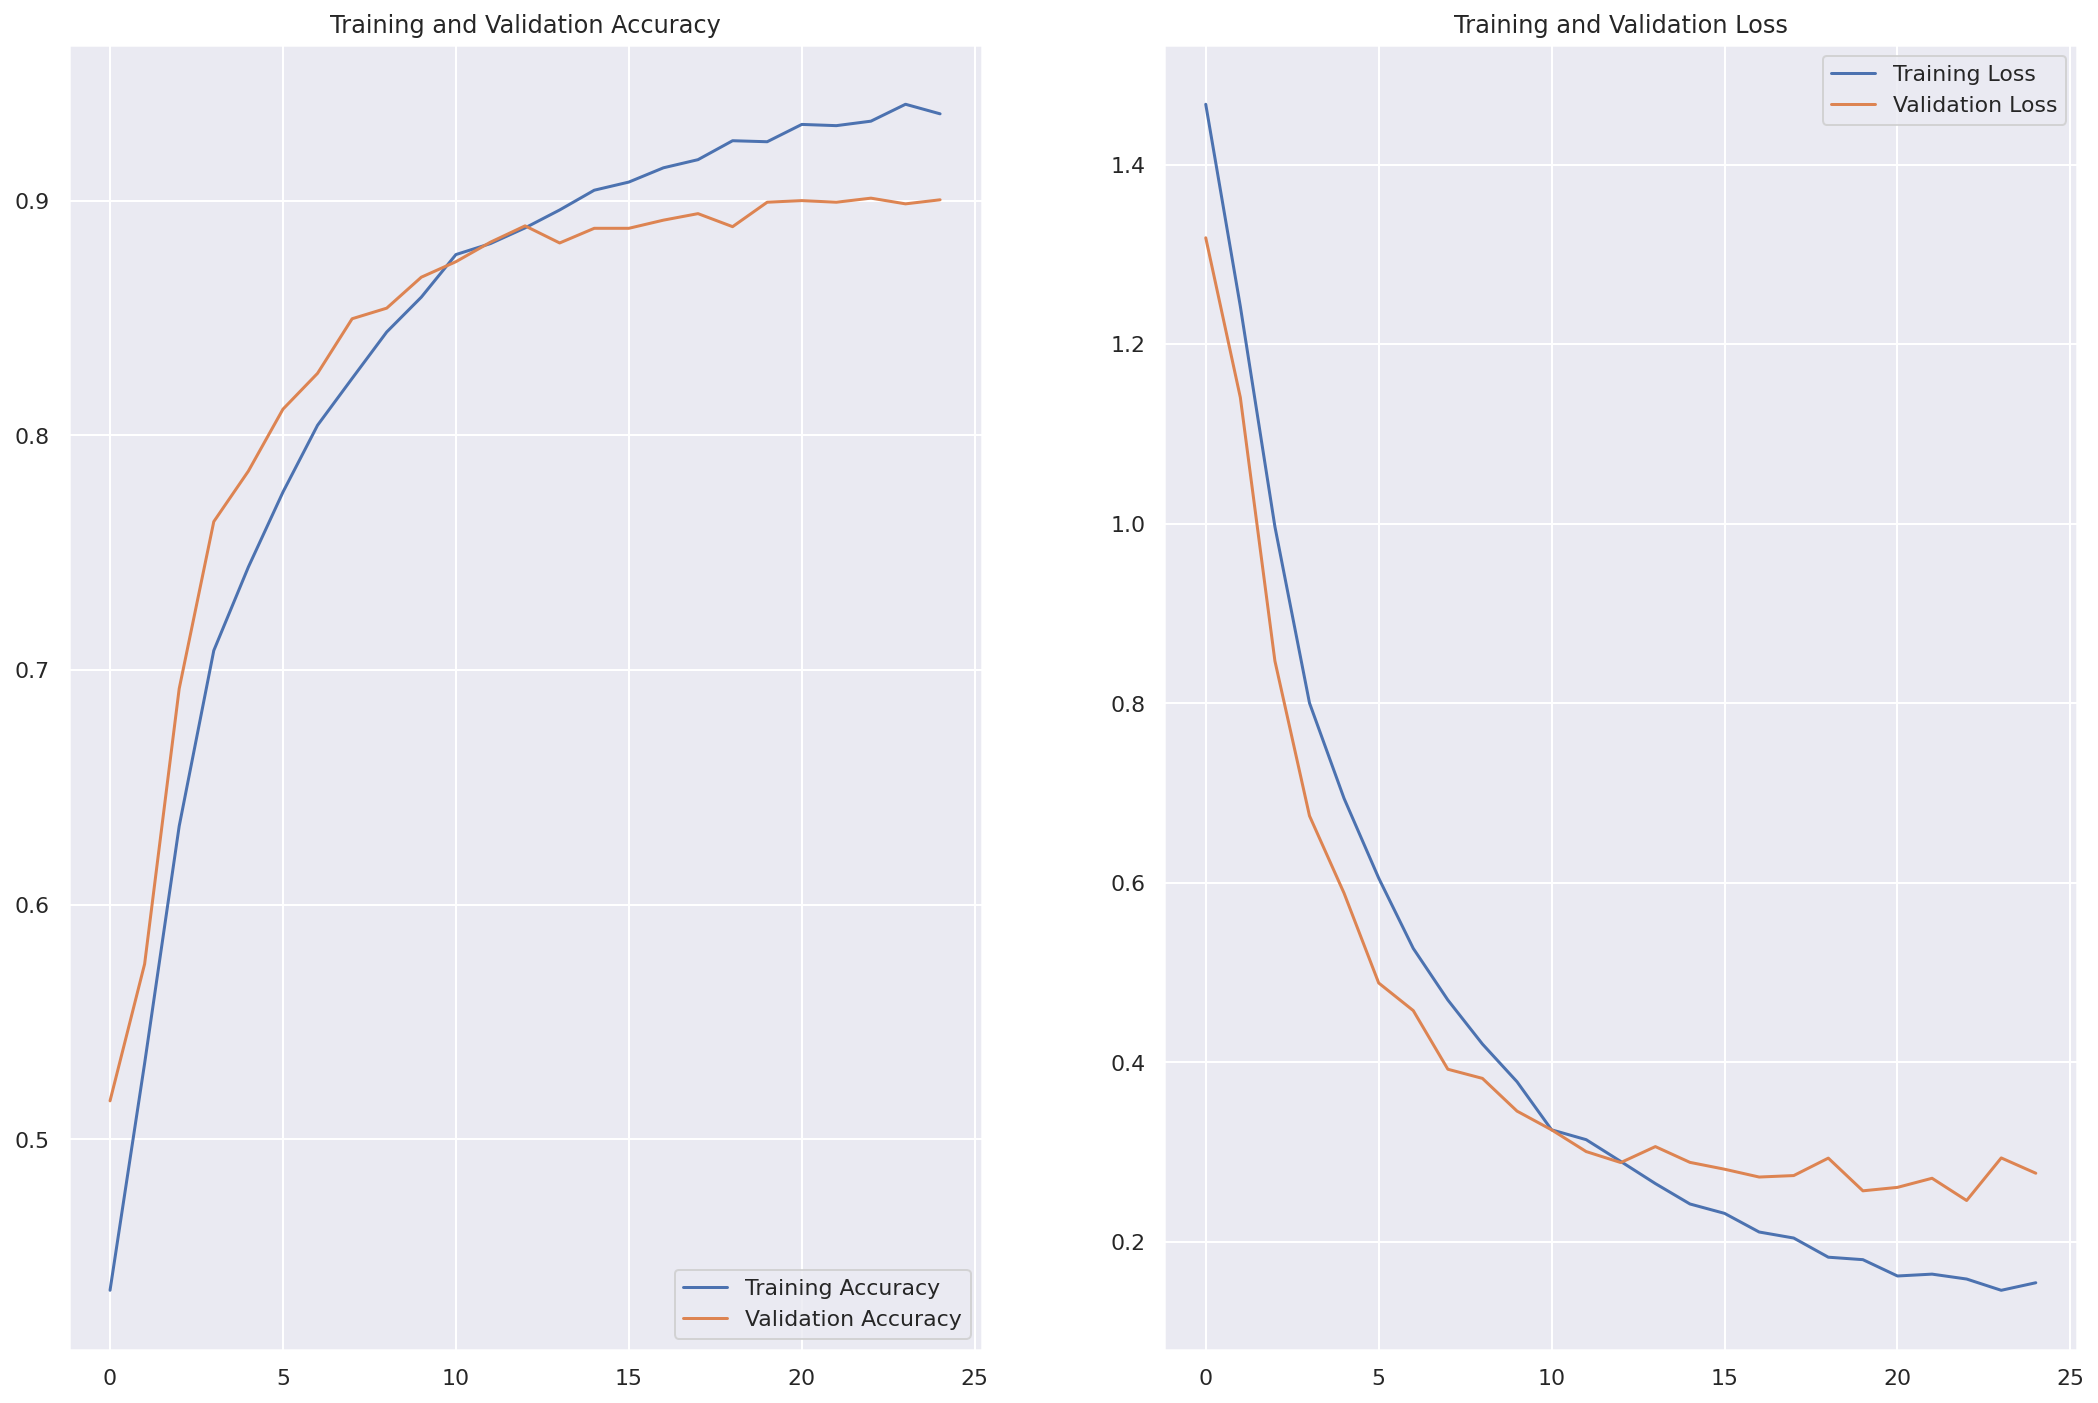

In [28]:
# plot of train vs validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(18, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observation**
- Here we can see our model is peforming good since both **accuracy and loss**
are increasing and decreasing respectively.
- Since we see both train and val loss is comparable that also means model is **not overfitting**.

<a name=section6></a>

---
## 6. Prediction on test set
---

In [29]:
predict_y = model.predict(X_test_pad) # predict using model
classes_y = np.argmax(predict_y,axis=1) # getting class labels

In [30]:
submission = pd.DataFrame({'Id':test_data['Id'],'Sentiment':classes_y}) # our submission file


In [31]:
submission.head()

,Id,Sentiment
0,10779,1
1,2247,3
2,11765,0
3,14390,0
4,388,0


In [32]:
submission['Sentiment']= submission.Sentiment.replace({0:'joy',1:'anger',2:'love',3:'sadness',4:'fear',5:'surprise'}) # replacing our no labels with actual labels

In [33]:
submission.to_csv('Submission.csv',header=False,index=False) # submitting our file

In [35]:
# original y test labels
y_df = pd.read_csv('/content/emotion_y_test.csv', names=['Id', 'Sentiment'])
y_df.head()

,Id,Sentiment
0,10779,fear
1,2247,sadness
2,11765,joy
3,14390,joy
4,388,joy


In [36]:
print('Accuracy score for test data is:', accuracy_score(y_df['Sentiment'],submission['Sentiment']))

Accuracy score for test data is: 0.8991666666666667


<a name=section7></a>

---
## 7. Conclusion
---

- We used **pretrained embedding glove** to improve our model performance.
- We also used **CuDNN** , which is a faster implimentation of **LSTM**.
- We saw how **cleaning** the data helped our accuracy.
- Also using **dropouts** helped our model.
